- Get artifact
- Get edges forming one
- Get adjacent edges
- Plot by CES with nodes, clipped
- Get edges intersecting the artifact in the simplified network
- Plot simplified with nodes, clipped

In [ ]:
import matplotlib.pyplot as plt
from libpysal import graph
from matplotlib.lines import Line2D
from neatnet import (
    consolidate_nodes,
    fix_topology,
    get_artifacts,
    remove_interstitial_nodes,
)
from neatnet.simplify import (
    _classify_strokes,
    _identify_non_planar,
    _link_nodes_artifacts,
    continuity,
)

import core

In [2]:
case = "Liège"

Read road data

In [3]:
original = core.utils.read_original(case)
simplified = core.utils.read_results(case, "neatnet", original.crs)

Extract first part of the code from neatify.

In [4]:
eps = 1e-4
max_segment_length = 1

This takes bits from neatify, neatify_loop and neatify_singletons to get to the point where neatify assigns the typology.

In [5]:
roads = fix_topology(original, eps=eps)
# Merge nearby nodes (up to double of distance used in skeleton).
roads = consolidate_nodes(roads, tolerance=max_segment_length * 2.1)

# Identify artifacts
artifacts, threshold = get_artifacts(roads)
_, r_idx = roads.sindex.query(artifacts.geometry, predicate="contains")
# Dropping may lead to new false nodes – drop those
roads = remove_interstitial_nodes(roads.drop(roads.index[r_idx]))

# Filter singleton artifacts
rook = graph.Graph.build_contiguity(artifacts, rook=True)

# Keep only those artifacts which occur as isolates,
# e.g. artifacts that are not part of a larger intersection
artifacts = artifacts.loc[artifacts.index.intersection(rook.isolates)].copy()

nodes, artifacts = _link_nodes_artifacts("singletons", roads, artifacts, eps)

# Compute number of stroke groups per artifact
roads, _ = continuity(roads)
artifacts = _classify_strokes(artifacts, roads)

# Filter artifacts caused by non-planar intersections
artifacts = _identify_non_planar(artifacts, roads)

# Count intersititial nodes (primes)
_prime_count = artifacts["node_count"] - artifacts[["C", "E", "S"]].sum(axis=1)
artifacts["interstitial_nodes"] = _prime_count

# Define the type label
ces_type = []
for x in artifacts[["node_count", "C", "E", "S"]].itertuples():
    ces_type.append(f"{x.node_count}{'C' * x.C}{'E' * x.E}{'S' * x.S}")
artifacts["ces_type"] = ces_type

Count occurences to know how large the plot shall be.

In [6]:
all_types = artifacts.ces_type.value_counts().sort_index()

Drop a non-planar case that is not part of the typology.

In [8]:
all_types = all_types.drop("1")  # non planar

Count types per number of nodes.

In [ ]:
counts = {k: all_types.index.str.startswith(str(k)).sum() for k in range(1, 8)}
counts

{1: np.int64(2),
 2: np.int64(5),
 3: np.int64(12),
 4: np.int64(12),
 5: np.int64(7),
 6: np.int64(2),
 7: np.int64(1)}

Plot the complete typology without proposed solutions.

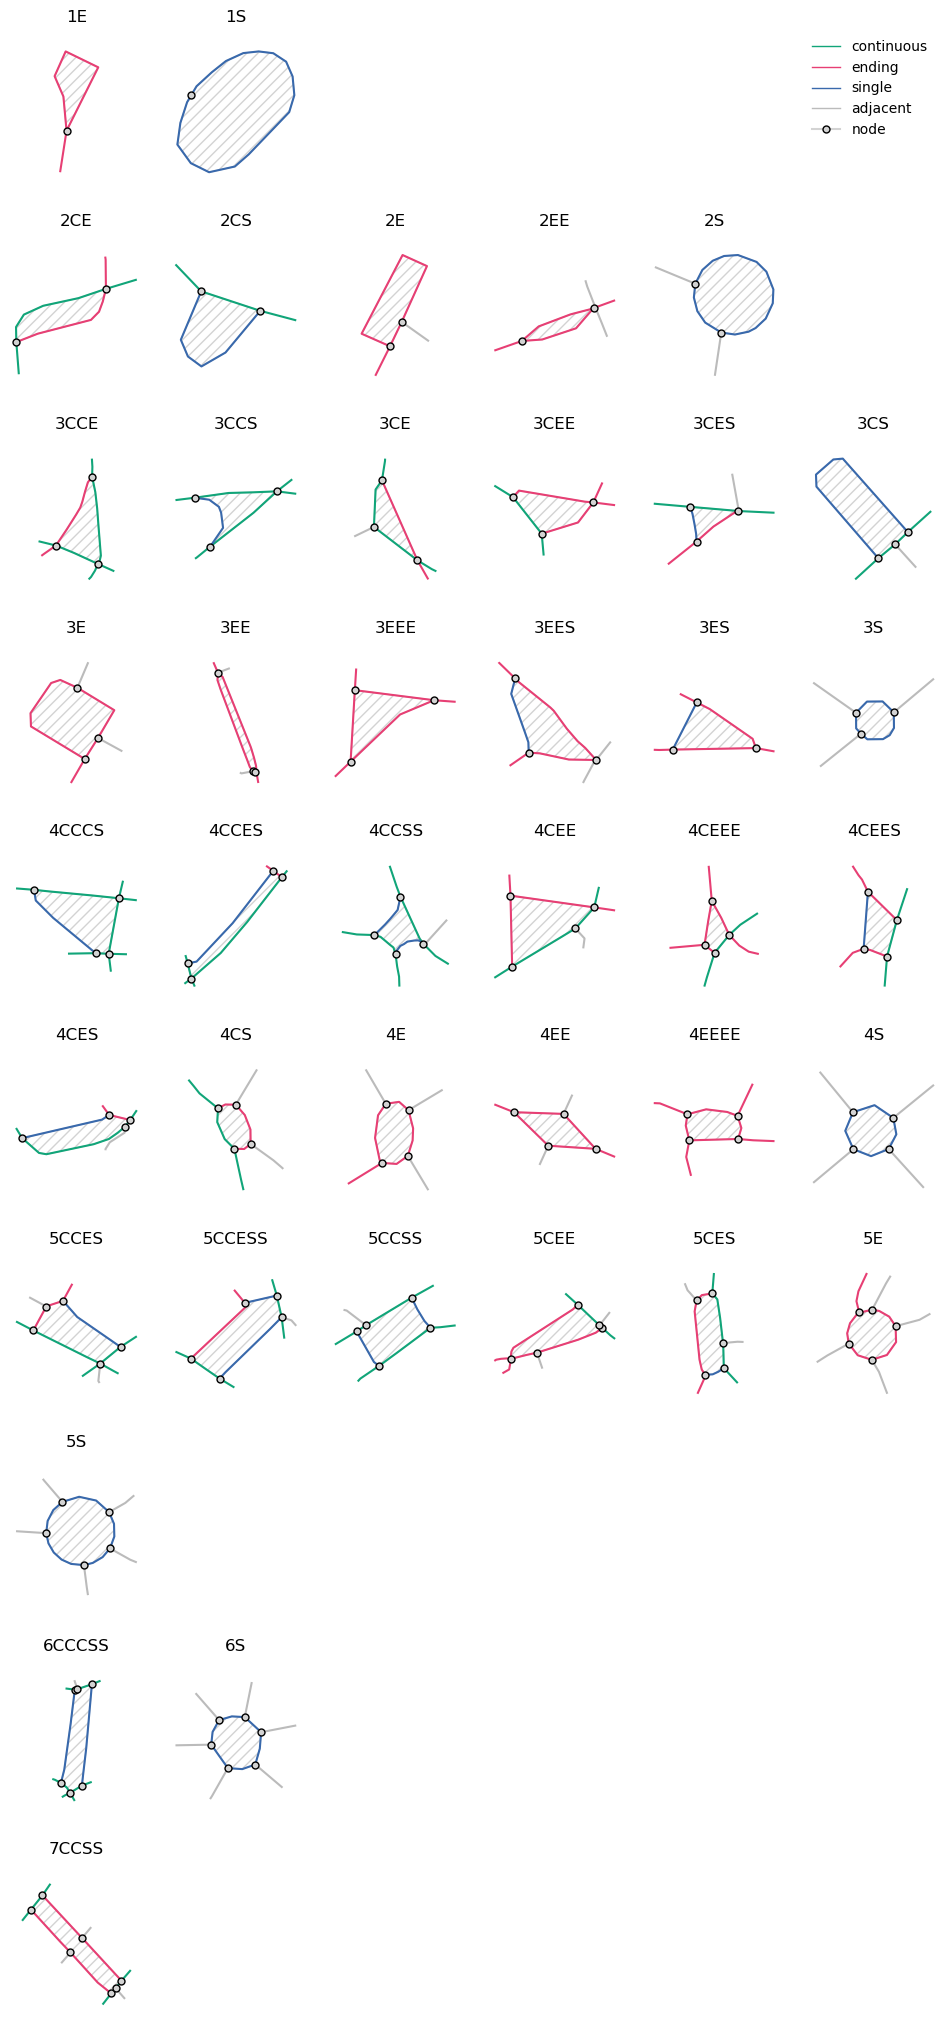

In [11]:
fig, axs = plt.subplots(10, 6, figsize=(12, 26))
row = 0
for i in range(1, 8):
    ces_i = all_types.index[all_types.index.str.startswith(str(i))]
    if len(ces_i) < 7:
        for loc, ces in enumerate(ces_i):
            geom = artifacts[artifacts.ces_type == ces].geometry.iloc[0]
            core.viz.ces.plot_ces(roads, geom, axs[row, loc])
            axs[row, loc].set_title(ces)
        row += 1
    else:
        for loc, ces in enumerate(ces_i[:6]):
            geom = artifacts[artifacts.ces_type == ces].geometry.iloc[0]
            core.viz.ces.plot_ces(roads, geom, axs[row, loc])
            axs[row, loc].set_title(ces)
        row += 1
        for loc, ces in enumerate(ces_i[6:]):
            geom = artifacts[artifacts.ces_type == ces].geometry.iloc[0]
            core.viz.ces.plot_ces(roads, geom, axs[row, loc])
            axs[row, loc].set_title(ces)
        row += 1
for ax in axs.flat:
    ax.set_axis_off()

legend_elements = [
    Line2D([0], [0], color="#11A579", lw=1, label="continuous"),
    Line2D([0], [0], color="#E73F74", lw=1, label="ending"),
    Line2D([0], [0], color="#3969AC", lw=1, label="single"),
    Line2D([0], [0], color="#bbbbbb", lw=1, label="adjacent"),
    Line2D(
        [0],
        [0],
        marker="o",
        color="lightgrey",
        markeredgecolor="k",
        markersize=5,
        label="node",
    ),
]

# Add legend to the plot
axs[0, -1].legend(handles=legend_elements, loc="upper right", frameon=False)
for ext in ["png", "svg", "pdf"]:
    plt.savefig(f"../../illustrations/ces_liege_ces_only.{ext}", bbox_inches="tight")

Plot just the solutions.

/Users/martin/dev/uscuni/simplification/core/viz/ces.py:91: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  vertices.plot(ax=ax, facecolor="lightgrey", edgecolor="k", markersize=25, zorder=2)
/Users/martin/dev/uscuni/simplification/core/viz/ces.py:91: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  vertices.plot(ax=ax, facecolor="lightgrey", edgecolor="k", markersize=25, zorder=2)


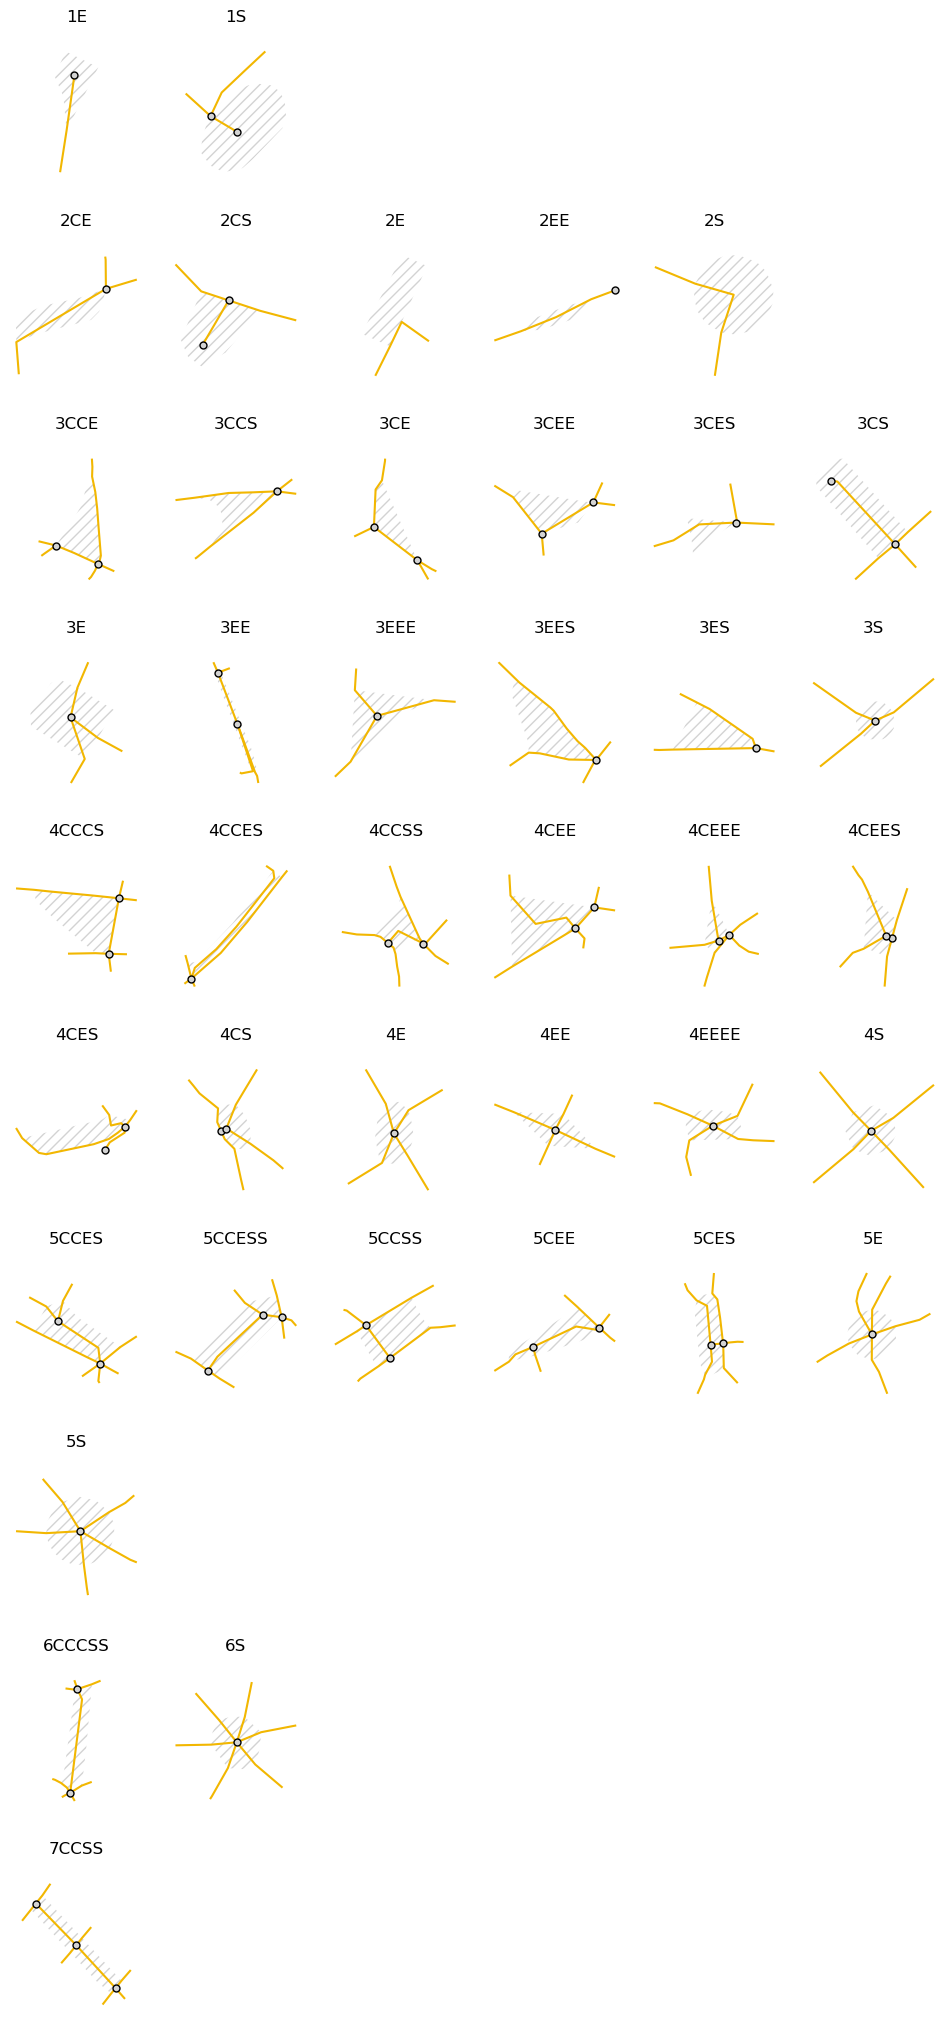

In [12]:
fig, axs = plt.subplots(10, 6, figsize=(12, 26))
row = 0
for i in range(1, 8):
    ces_i = all_types.index[all_types.index.str.startswith(str(i))]
    if len(ces_i) < 7:
        for loc, ces in enumerate(ces_i):
            geom = artifacts[artifacts.ces_type == ces].geometry.iloc[0]
            core.viz.ces.plot_simplified(simplified, geom, axs[row, loc])
            axs[row, loc].set_title(ces)
        row += 1
    else:
        for loc, ces in enumerate(ces_i[:6]):
            geom = artifacts[artifacts.ces_type == ces].geometry.iloc[0]
            core.viz.ces.plot_simplified(simplified, geom, axs[row, loc])
            axs[row, loc].set_title(ces)
        row += 1
        for loc, ces in enumerate(ces_i[6:]):
            geom = artifacts[artifacts.ces_type == ces].geometry.iloc[0]
            core.viz.ces.plot_simplified(simplified, geom, axs[row, loc])
            axs[row, loc].set_title(ces)
        row += 1
for ax in axs.flat:
    ax.set_axis_off()
for ext in ["png", "svg", "pdf"]:
    plt.savefig(f"../../illustrations/ces_liege_solution.{ext}", bbox_inches="tight")

Full typology for the appendix.

/Users/martin/dev/uscuni/simplification/core/viz/ces.py:91: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  vertices.plot(ax=ax, facecolor="lightgrey", edgecolor="k", markersize=25, zorder=2)
/Users/martin/dev/uscuni/simplification/core/viz/ces.py:91: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  vertices.plot(ax=ax, facecolor="lightgrey", edgecolor="k", markersize=25, zorder=2)


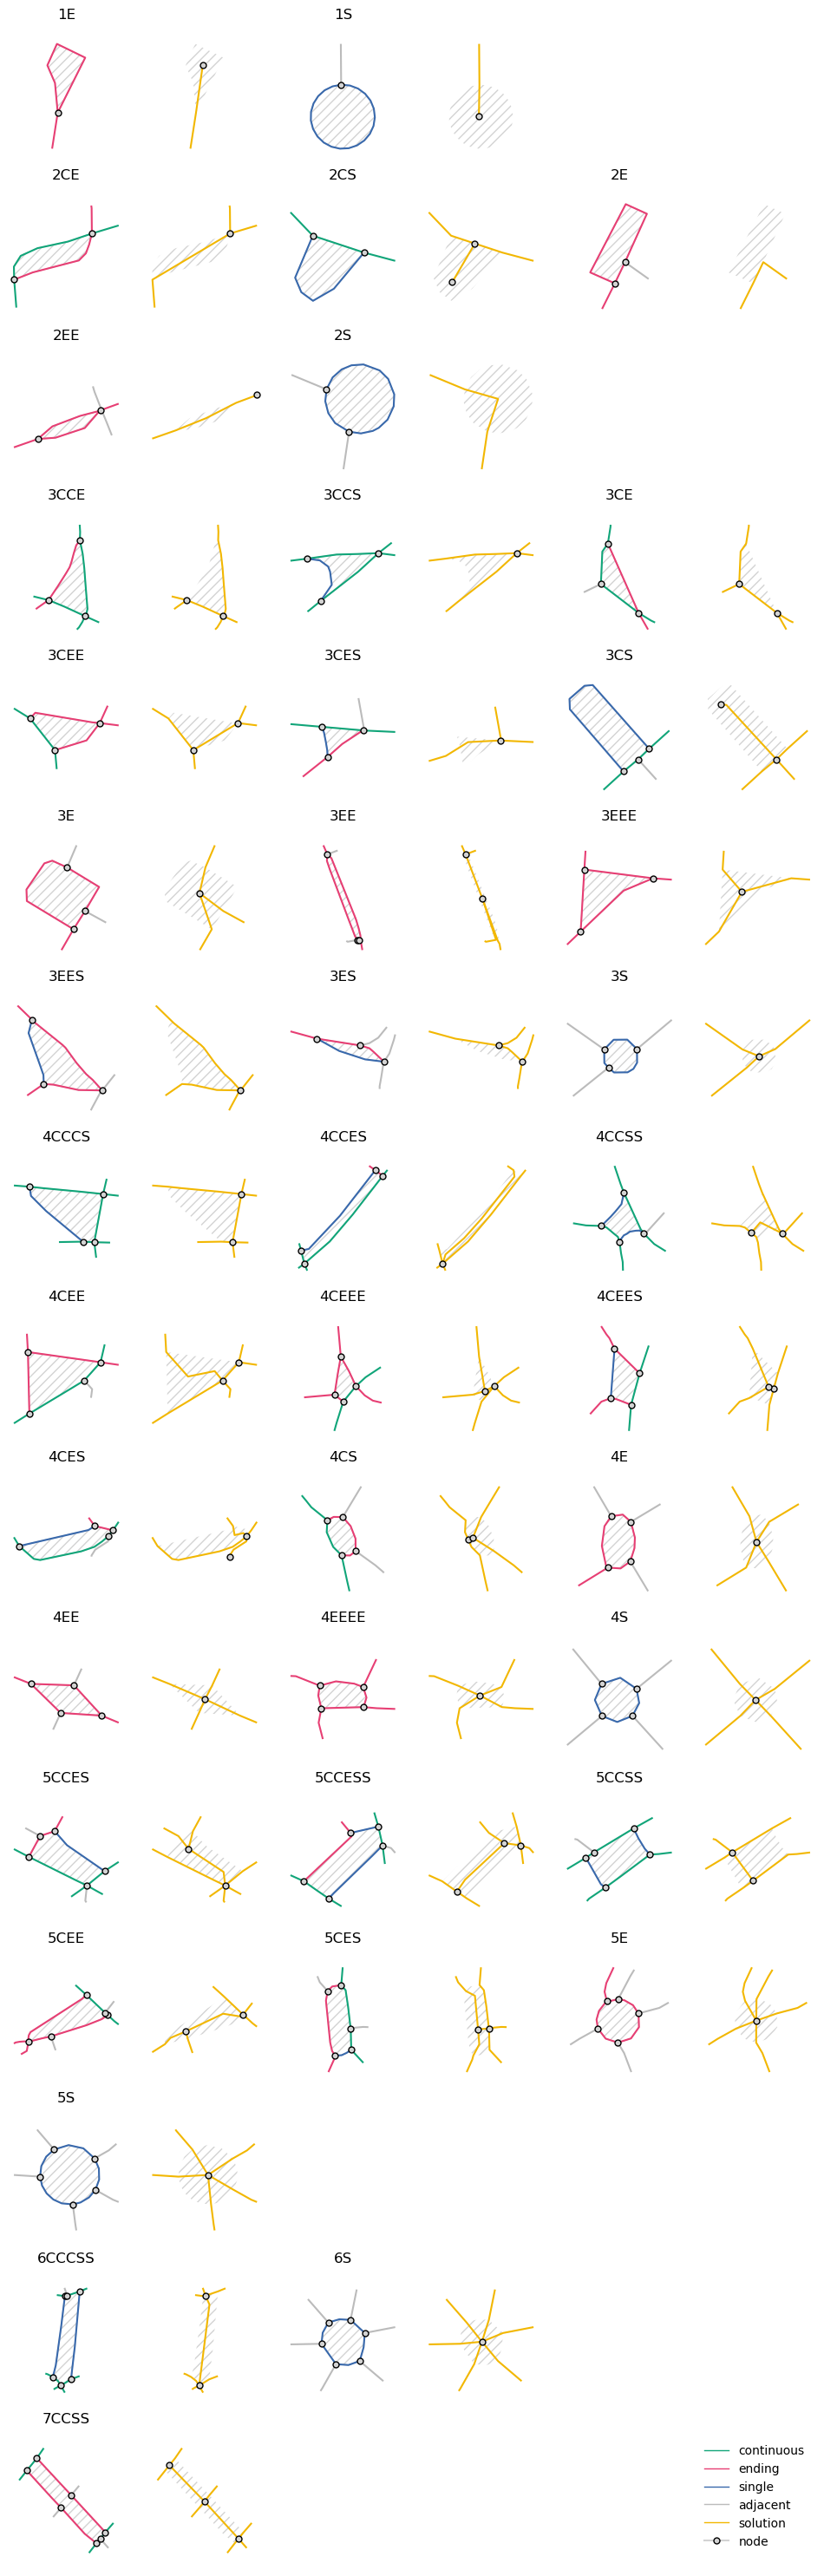

In [19]:
fig, axs = plt.subplots(16, 6, figsize=(12, 38))
row = 0
for i in range(1, 8):
    ces_i = all_types.index[all_types.index.str.startswith(str(i))]
    loc = 0
    for ces in ces_i:
        if loc >= axs.shape[1]:  # Move to the next row if current row is full
            row += 1
            loc = 0
        if ces in ["1S", "3ES"]:  # that first example is weird
            geom = artifacts[artifacts.ces_type == ces].geometry.iloc[-1]
        else:
            geom = artifacts[artifacts.ces_type == ces].geometry.iloc[0]
        core.viz.ces.plot_ces(roads, geom, axs[row, loc])
        axs[row, loc].set_title(ces)
        core.viz.ces.plot_simplified(simplified, geom, axs[row, loc + 1])
        loc += 2
    row += 1
for ax in axs.flat:
    ax.set_axis_off()

legend_elements = [
    Line2D([0], [0], color="#11A579", lw=1, label="continuous"),
    Line2D([0], [0], color="#E73F74", lw=1, label="ending"),
    Line2D([0], [0], color="#3969AC", lw=1, label="single"),
    Line2D([0], [0], color="#bbbbbb", lw=1, label="adjacent"),
    Line2D([0], [0], color="#F2B701", lw=1, label="solution"),
    Line2D(
        [0],
        [0],
        marker="o",
        color="lightgrey",
        markeredgecolor="k",
        markersize=5,
        label="node",
    ),
]

# Add legend to the plot
axs[-1, -1].legend(handles=legend_elements, loc="upper right", frameon=False)
for ext in ["png", "svg", "pdf"]:
    plt.savefig(f"../../illustrations/ces_liege.{ext}", bbox_inches="tight")

Subset for the paper.

/Users/martin/dev/uscuni/simplification/core/viz/ces.py:91: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  vertices.plot(ax=ax, facecolor="lightgrey", edgecolor="k", markersize=25, zorder=2)


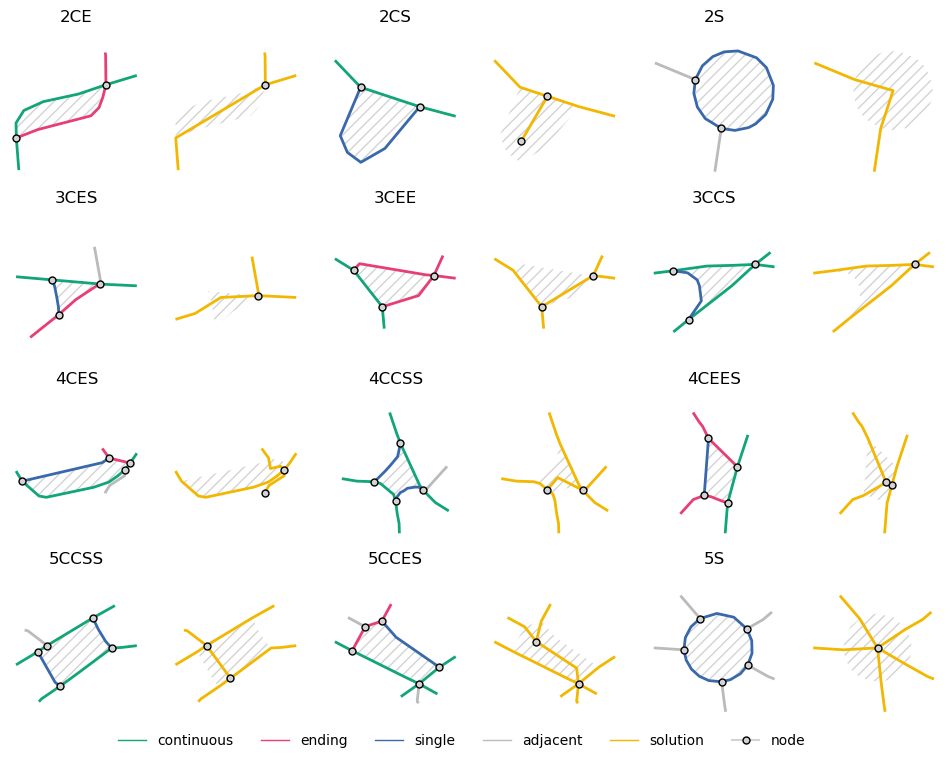

In [15]:
fig, axs = plt.subplots(4, 6, figsize=(12, 9))
row = 0
ces_subset = [
    "2CE",
    "2CS",
    "2S",
    "3CES",
    "3CEE",
    "3CCS",
    "4CES",
    "4CCSS",
    "4CEES",
    "5CCSS",
    "5CCES",
    "5S",
]
loc = 0
for ces in ces_subset:
    if loc >= axs.shape[1]:  # Move to the next row if current row is full
        row += 1
        loc = 0
    geom = artifacts[artifacts.ces_type == ces].geometry.iloc[0]
    core.viz.ces.plot_ces(roads, geom, axs[row, loc], linewidth=2)
    axs[row, loc].set_title(ces)
    core.viz.ces.plot_simplified(simplified, geom, axs[row, loc + 1], linewidth=2)
    loc += 2
for ax in axs.flat:
    ax.set_axis_off()

legend_elements = [
    Line2D([0], [0], color="#11A579", lw=1, label="continuous"),
    Line2D([0], [0], color="#E73F74", lw=1, label="ending"),
    Line2D([0], [0], color="#3969AC", lw=1, label="single"),
    Line2D([0], [0], color="#bbbbbb", lw=1, label="adjacent"),
    Line2D([0], [0], color="#F2B701", lw=1, label="solution"),
    Line2D(
        [0],
        [0],
        marker="o",
        color="lightgrey",
        markeredgecolor="k",
        markersize=5,
        label="node",
    ),
]

# Add legend to the plot
axs[-1, 1].legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(2.2, -0.3),
    frameon=False,
    ncols=6,
)
for ext in ["png", "svg", "pdf"]:
    plt.savefig(f"../../illustrations/ces_liege_subset.{ext}", bbox_inches="tight")